### Importar Modulos 

In [17]:
#Importing modules and font style
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 16
plt.rcParams['xtick.labelsize']=16
plt.rcParams['ytick.labelsize']=16

### Funciones 

In [2]:
def energy_afmtip(results_file_path):
    """
    Read energy and distances from Pygbe results file, for 
    a afm-tip example
    -------
    Inputs:
        results_file_path: Pygbe results file
    Return:
        None
    """
    results_file = open(results_file_path,'r')
    results_data = results_file.read().split('\n')
    for line in results_data:
        if 'Surface 0' in line:
            surf = 0
        elif 'Surface 1' in line:
            surf = 1
        elif 'box center' in line:
            aux = line.split(': ')
            if surf == 0:
                line = aux[1].split(',')
                r_surf1 = np.array([float(line[0]),float(line[1]),float(line[2])])
            elif surf == 1:
                line = aux[1].split(',')
                r_surf2 = np.array([float(line[0]),float(line[1]),float(line[2])])
    aux = results_data[-6].split('= ')
    E_solv = float(aux[1].split(' ')[0])
    aux = results_data[-5].split('= ')
    E_surf = float(aux[1].split(' ')[0])
    aux = results_data[-4].split('= ')
    E_coul = float(aux[1].split(' ')[0])
    results_file.close()
    
    return r_surf1, r_surf2, E_solv, E_surf, E_coul

def readpqr(filename, N):
    """
    Read pqr-format file
    -------
    Inputs:
        filename: file .pqr with point-charge-radius format
        N: number of solute charges present in filename
    Return:
        position: Array size (Nx3) with charges positions
        q: Array size (Nx1) with charges values
        amino_acid_name: Array (Nx1) with charges amino acid name
        amino_acid_number: Array (Nx1) with charges amino acid name 
        atom_name: Array (Nx1) with atom_names
        atom_number: Array (Nx1) with atom_numbers  
    """
    pqr_file = open(filename,'r')
    position = np.zeros((N,3))
    q = np.zeros(N)
    amino_acid_name = np.array(q, dtype=np.string_)
    atom_name = np.array(q, dtype=np.string_)
    chain = np.array(q, dtype=np.string_)
    amino_acid_number = np.zeros(N, dtype=int)
    counter = 0
    for i, line in enumerate(pqr_file):
        line_split = line.split()
        if line_split[0] == 'ATOM':
            position[counter,0] = float(line_split[6])
            position[counter,1] = float(line_split[7])
            position[counter,2] = float(line_split[8])
            q[counter] = float(line_split[9])
            amino_acid_name[counter] = line_split[3]
            amino_acid_number[counter] = int(line_split[5])
            atom_name[counter] = line_split[2]
            chain[counter] = line_split[4]
            counter += 1
        
    return position, q, amino_acid_name, amino_acid_number, atom_name,chain

def compute_force_fixedcharge(dphi, q, units='kcal'):
    """
    Compute forces due solute charges in the solute
    from dphi.txt file and q charges array
    -------
    Inputs:
        dphi: file .pqr with point-charge-radius format
        q: number of solute charges present in filename
    Return:
        force: Array size (Nx3) with forces for solute charges
        force_magnitude: Array size (Nx1) with forces magnitude for solute charges 
        total_force: Array size (1x3) with total force due solute charges
        total_force_magnitude: Array (1x1) with total force magnitude
    """
    if units == 'kcal':
        factor = 4*np.pi*332.0636817823836 #1e-3*Na*1e10*(qe**2/(ep_vacc*4*numpy.pi*cal2J))
    elif units == 'kJ':
        factor = 4.184*4*np.pi*332.0636817823836
    elif units == 'pN':
        factor = 69.467*4*np.pi*332.0636817823836
        
    force = -np.transpose(np.transpose(dphi)*q)
    force_magnitude = np.sqrt(np.sum(force**2, axis=1))
    total_force = np.sum(force, axis=0)
    total_force_magnitude = np.sqrt(np.sum(total_force**2))

    return factor*force, factor*force_magnitude, factor*total_force, factor*total_force_magnitude

def forces_fixedcharge_zika(dir,distance):
    """
    Read from directory with results file to get 
    fixed charge forces for afm-zika case
    -------
    Inputs:
        dir: directory with results file
        distance: afm to tip distance between centres
    Return:
        fqf: Array size (1x3) with total force due solute charges
        fqf_mag: Array (1x1) with total force magnitude
    """    
    dir_dphir = dir + '\\tip_charge-2.5_rad150\\zatsc' + str(distance) + '\\dphir.txt'
    dphir = np.loadtxt(dir_dphir)
    N = len(dphir)
    _, q, _, _, _,_ = readpqr(dir + '\\ZIKV_6CO8_aa_charge_vdw_addspace.pqr',N)
    _, _, fqf, fqf_mag = compute_force_fixedcharge(dphir,q)

    return fqf, fqf_mag

In [3]:
# Read files with solvation energy results
os.chdir('outputs\\outsZikaWithQ')
files = os.listdir()
files.append(files[0])
files.remove(files[-1])
r_surf1 = np.zeros([len(files),3])
r_surf2 = np.zeros([len(files),3])
E_solv = np.zeros(len(files))
E_surf = np.zeros(len(files))
E_coul = np.zeros(len(files))
j=0
for file in files:
    r_surf1[j], r_surf2[j], E_solv[j], E_surf[j], E_coul[j] = energy_afmtip(file)
    j +=1
os.chdir('..\\..')
x = r_surf2.swapaxes(0,1)[0] 
dE_solvdx_centered = 69.467*(E_solv[2:]-E_solv[:-2])/(x[2:]-x[:-2]) #Centered difference in (pN)


# Fixed charge force calculation with dphir file from Pygbe
distances = [386,388,390,392,394,396,398,400,404,434,484,884,1384]
fqf = np.zeros([len(distances),3])
j=0
for dist in distances:
    fqf[j,:],_ = forces_fixedcharge_zika('zika_afm',dist)
    j+=1

# Boundary force from Pygbe calculation
fdb = np.zeros([len(distances),3])
fib = np.zeros([len(distances),3])
d = np.zeros([len(distances),1])
to_kcalmolA = 4*np.pi*332.0636817823836
f_boundary = np.loadtxt('boundary_forces_zika.txt',delimiter=' ')
for j in range(len(f_boundary)):
    d[j] = f_boundary[j,0]
    fdb[j] =to_kcalmolA*f_boundary[j,1:4]
    fib[j] =to_kcalmolA*f_boundary[j,4:]

# Binding force by substracting solvation force for capsid far away from tip
F_terms = 69.467*(fqf[:]+fdb[:]+fib[:]-fqf[-1]-fdb[-1]-fib[-1])

# MVM fitting function (Podgornik et al. Nanoscale, 2015)
def forces_MVM(d,B,A=0,k=1/6.8):
    return (A*np.exp(-2*k*d)+B*np.exp(-k*d))/(1-np.exp(-2*k*d))



### Energy Plots

In [4]:
plt.figure(figsize=(10,6),dpi=150)
plt.plot(r_surf2.swapaxes(0,1)[0][:-2], E_solv[:-2], color='black', marker='o',markerfacecolor='blue',markeredgecolor='blue', markersize=4,linestyle='-')
plt.title('Solvation Energy capsid')
plt.xlabel('x ($\AA$)');
plt.ylabel('$\Delta G_{solv}$ (kcal/mol)');
plt.savefig('plots\\Energy_solvation.png',dpi=300, bbox_inches='tight')
plt.close()

plt.figure(figsize=(10,6),dpi=150)
plt.plot(r_surf2.swapaxes(0,1)[0][:-2], E_surf[:-2], color='black', marker='o',markerfacecolor='blue',markeredgecolor='blue', markersize=4,linestyle='-')
plt.title('Surface Energy tip')
plt.xlabel('x ($\AA$)');
plt.ylabel('$\Delta G_{surf}$ (kcal/mol)')
plt.savefig('plots\\Energy_surface.png',dpi=300, bbox_inches='tight')
plt.close()

plt.figure(figsize=(10,6),dpi=150)
plt.plot(r_surf2.swapaxes(0,1)[0], E_coul, color='black', marker='o',markerfacecolor='blue',markeredgecolor='blue', markersize=4,linestyle='-')
plt.title('Coulomb Energy')
plt.xlabel('x ($\AA$)');
plt.ylabel('$\Delta G_{coul}$ (kcal/mol)')
plt.savefig('plots\\Energy_coulomb.png',dpi=300, bbox_inches='tight')
plt.close()

### Force components plots

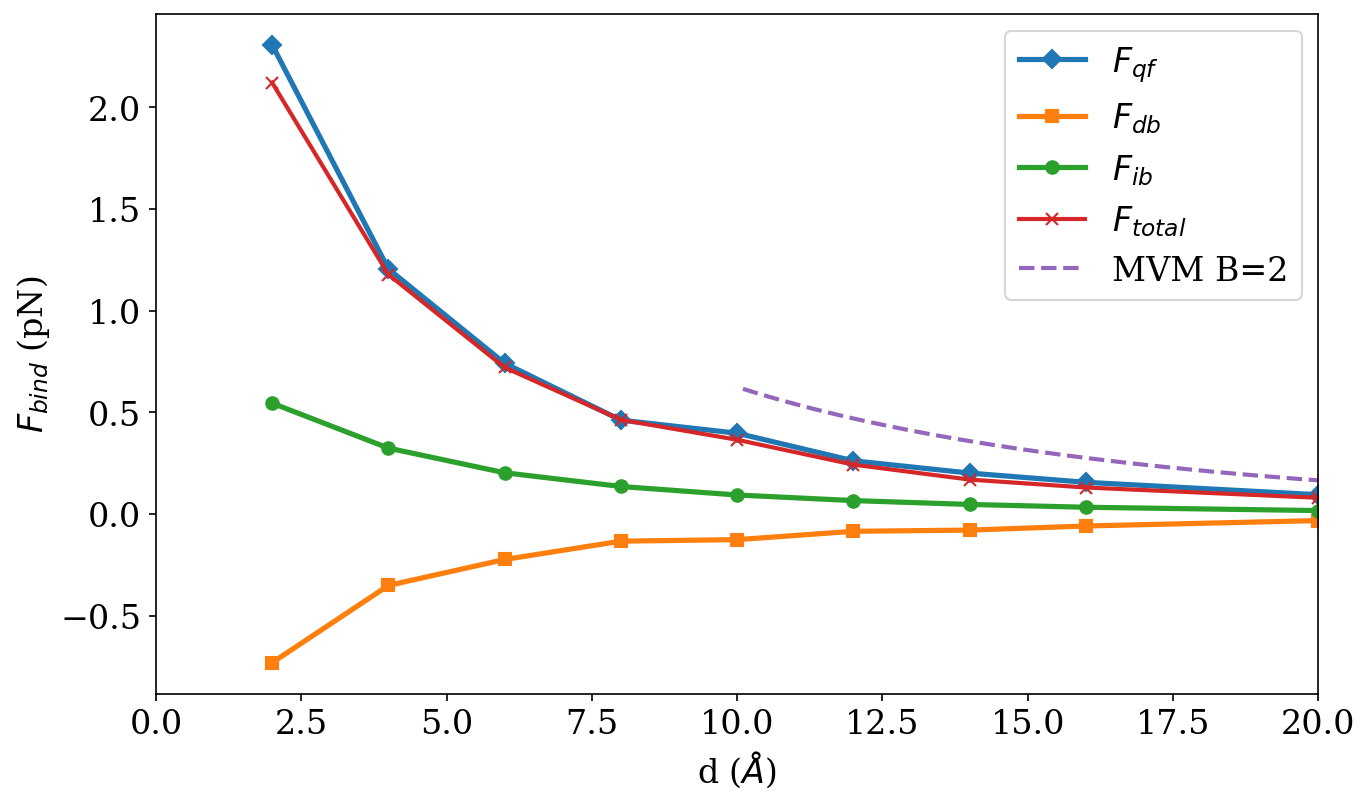

In [18]:
d = np.array([386,388,390,392,394,396,398,400,404,434,484,884,1384]) -384 #Distances from tip to afm in Angstrom
dd = np.arange(394,434,0.1)

plt.figure(figsize=(10,6),dpi=70)
plt.plot(d,69.467*fqf.swapaxes(0,1)[0], marker='D',label='$F_{qf}$')
plt.plot(d,69.467*fdb.swapaxes(0,1)[0], marker='s',label='$F_{db}$')
plt.plot(d,69.467*fib.swapaxes(0,1)[0], marker='o',label='$F_{ib}$')
plt.plot(d,69.467*fqf.swapaxes(0,1)[0]+69.467*fdb.swapaxes(0,1)[0]+69.467*fib.swapaxes(0,1)[0], marker='x',label='$F_{total}$')
plt.title('Solvation forces components (Capsid)')
plt.xlim([0,14])
plt.xlabel('d ($\AA$)');
plt.ylabel('$F_{solv}$ (pN)')
plt.legend()
plt.savefig('plots\\Solvation_forces_components_capsid_zoomed.png',dpi=300, bbox_inches='tight')
plt.close()

plt.figure(figsize=(10,6),dpi=150)
plt.plot(d,-69.467*fqf.swapaxes(0,1)[0]+69.467*fqf.swapaxes(0,1)[0][-1], marker='D',label='$F_{qf}$',linewidth = 2.5)
plt.plot(d,-69.467*fdb.swapaxes(0,1)[0]+69.467*fdb.swapaxes(0,1)[0][-1], marker='s',label='$F_{db}$',linewidth = 2.5)
plt.plot(d,-69.467*fib.swapaxes(0,1)[0]+69.467*fib.swapaxes(0,1)[0][-1], marker='o',label='$F_{ib}$',linewidth = 2.5)
plt.plot(d,-F_terms.swapaxes(0,1)[0], marker='x',label='$F_{total}$',linewidth = 2)
plt.plot(dd[1:]-384,forces_MVM(dd[1:]-384,2,k=0.125),label='MVM B=2',linestyle='--',linewidth = 2)
plt.xlim([0,20])
plt.xlabel('d ($\AA$)');
plt.ylabel('$F_{bind}$ (pN)')
plt.legend()
plt.savefig('plots\\Binding_forces_components_capsid_zoomed.png',dpi=300, bbox_inches='tight')
plt.show()
plt.close()